In [1]:
from climada.hazard.base import Hazard
from climada.hazard.low_flow import LowFlow
from climada.entity import ImpactFunc, ImpactFuncSet
from climada.entity.exposures import Exposures
from climada.engine import Impact
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import fiona
import datetime
import geopandas as gpd
from climada.util.coordinates import dist_to_coast

2020-06-30 17:06:39,613 - climada - DEBUG - Loading default config file: /home/stalzel/Python_projects/climada/climada_python/climada/conf/defaults.conf


In [3]:
lowflow = LowFlow()
lowflow.read_hdf5('hazards/computed_hazard_h08_gfdl-esm2m.h5')
#lowflow.read_hdf5('hazards/computed_hazard_lpjml_miroc5.h5')

2020-06-30 17:16:39,095 - climada.hazard.base - INFO - Reading hazards/computed_hazard_h08_gfdl-esm2m.h5


/home/zelie/Python_projects/climada_python/climada/util/plot.py:311: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


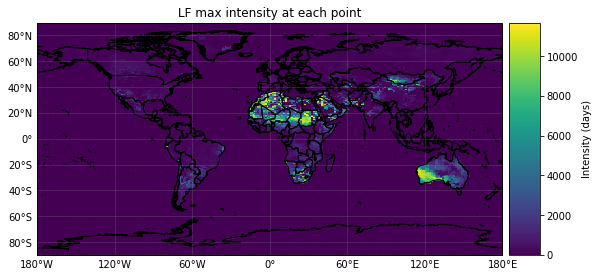

In [165]:
lowflow.plot_intensity(0)

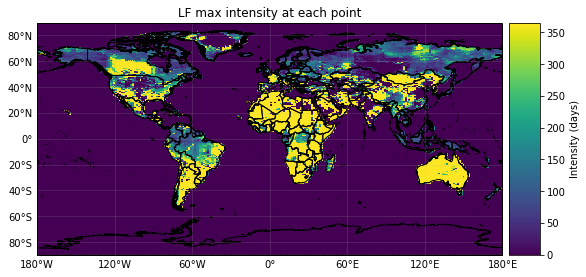

In [65]:
lowflow.plot_intensity(0,vmax=365)

In [8]:
wri_power_plants_path = 'power_plants_wri/global_power_plant_database.csv'


def load_exposure(bbox=[-180, -90, 180, 90], exp_path=wri_power_plants_path, primary_fuel='Nuclear'):
    """load exposure data from CSV
    Here, we use WRI power plant data from
    https://www.wri.org/publication/global-power-plant-database"""
    exp_df = pd.read_csv(exp_path)
    if primary_fuel:
        exp_df = exp_df[exp_df.primary_fuel==primary_fuel]
    # europe:
    exp_df = exp_df[exp_df.longitude>bbox[0]]
    exp_df = exp_df[exp_df.longitude<bbox[2]]
    exp_df = exp_df[exp_df.latitude>bbox[1]]
    exp_df = exp_df[exp_df.latitude<bbox[3]]
    exp_df['gen_mean']=exp_df[["generation_gwh_2013", "generation_gwh_2014", "generation_gwh_2015", "generation_gwh_2016", "generation_gwh_2017"]].mean(axis=1)
    exp_df['value']=exp_df[["gen_mean", "estimated_generation_gwh"]].mean(axis=1)
    # exp_df['value'] = exp_df.capacity_mw # provide value in MegaWatt
    
    #exp_df['latitude'] = 
    #exp_df['longitude'] = 
    exp_df['if_'] = 1
    exp_df['if_LF'] = 1
    # exp_df = exp_df.drop(columns=['country', 'name', 'gppd_idnr',
    #    'latitude', 'longitude', 'primary_fuel', 'owner', 'source', 'url',
    #    'geolocation_source', 'wepp_id', 'year_of_capacity_data',
    #    'generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015',
    #    'generation_gwh_2016', 'generation_gwh_2017',
    #    'estimated_generation_gwh', 'value', 'value_unit', 'if_TC', 'geometry'])
    

    # Generate Exposures from exposure-DataFranme
    exp_df = Exposures(exp_df)
    exp_df.value_unit = 'GWh'
    exp_df.ref_year = 2005
    exp_df.set_geometry_points() # set geometry attribute (shapely Points) from GeoDataFrame from latitude and longitude
    print('\n' + '\x1b[1;03;30;30m' + 'check method logs:' + '\x1b[0m')
    exp_df.check() # puts metadata that has not been assigned
    return exp_df

In [9]:
nuclear_exp = load_exposure(primary_fuel='Nuclear')
coal_exp = load_exposure(primary_fuel='Coal')
gas_exp = load_exposure(primary_fuel='Gas')
hydro_exp = load_exposure(primary_fuel='Hydro')

2020-06-30 17:21:52,938 - climada.util.coordinates - INFO - Setting geometry points.

check method logs:
2020-06-30 17:21:52,950 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-06-30 17:21:52,950 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-06-30 17:21:52,951 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2020-06-30 17:21:52,952 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2020-06-30 17:21:52,952 - climada.entity.exposures.base - INFO - centr_ not set.
2020-06-30 17:21:52,952 - climada.entity.exposures.base - INFO - deductible not set.
2020-06-30 17:21:52,953 - climada.entity.exposures.base - INFO - cover not set.
2020-06-30 17:21:52,954 - climada.entity.exposures.base - INFO - category_id not set.
2020-06-30 17:21:52,955 - climada.entity.exposures.base - INFO - region_id not set.
2020-06-30 17:21:53,102 - cl

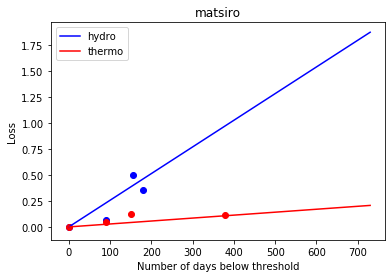

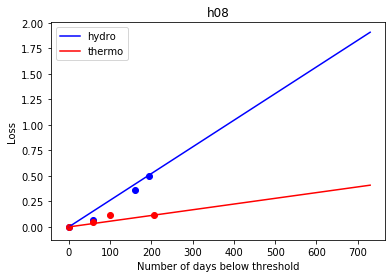

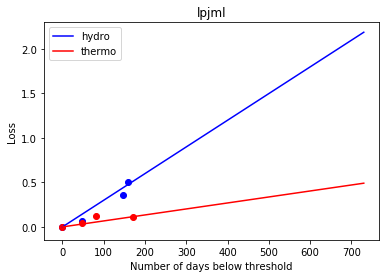

In [4]:
IF_data = pd.read_csv('IF_data2.csv')
hydro = IF_data[IF_data['Focus']=='Hydro']
thermo = IF_data[IF_data['Focus']!='Hydro']


col = {'thermo':'Red', 'hydro':'blue'}

data = {'thermo':thermo,'hydro':hydro}
if_slopes = {}

for h_model in ['matsiro','h08','lpjml']:
    fig, ax = plt.subplots()
    if_slopes[h_model] = {}
    for technology in ['hydro','thermo']:
        n = [0]+list(data[technology][h_model])
        d = [0]+list(data[technology]['loss'])

        x0 = np.linspace(0,365*2,100)
        s = np.polyfit(n,d,1)[0]
        if_slopes[h_model][technology] = s
        ax.plot(x0,s*x0,color = col[technology],label=technology)
        ax.scatter(n,d,color = col[technology])
        ax.set_xlabel('Number of days below threshold')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.set_title(" ".join([h_model]))
        

In [12]:
def init_IFS(s):
    """define impact function imp_fun and return impact function set (IFS)"""
    x0 = np.linspace(0,365,100)
    imp_fun = ImpactFunc()
    imp_fun.haz_type = 'LF'
    imp_fun.id = 1
    imp_fun.name = 'Low flow business interruption'
    imp_fun.intensity_unit = 'days'
    imp_fun.intensity = x0
    imp_fun.mdd = s*x0
 # loss to annual operation
    imp_fun.paa = imp_fun.intensity * 0 + 1
    # imp_fun.paa[imp_fun.intensity<mdm] = 0
    imp_fun.check()
    IFS = ImpactFuncSet()
    IFS.append(imp_fun)
    return IFS

IFS_lf = init_IFS(if_slopes['lpjml']['thermo'])

2020-06-25 15:41:06,257 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


In [15]:
imp_lf = Impact()
imp_lf.calc(nuclear_exp, IFS_lf, lowflow)

2020-06-25 15:41:39,281 - climada.entity.exposures.base - INFO - Matching 198 exposures with 259200 centroids.
2020-06-25 15:41:40,412 - climada.engine.impact - INFO - Calculating damage for 180 assets (>0) and 5797 events.


/home/zelie/Python_projects/climada_python/climada/util/plot.py:311: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


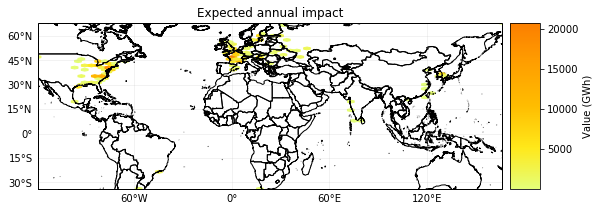

In [167]:
# impacts on nuclear power plants

imp_lf.plot_hexbin_eai_exposure(pop_name=False)

In [168]:
print(imp_lf.at_event[:1259].sum()) #2006-2030


1833902.1936207511


In [169]:
imp_lf.at_event[4538:].sum() #2075-2099


3928653.02659179

In [170]:
(lowflow.intensity>365).nnz/lowflow.intensity.nnz #only 1/1000 events last longer than a year

0.06711503992076966

In [172]:
test = np.where(lowflow.intensity.data>365)[0]
len(test)

53807

(array([11138.,  7282.,  4846.,  3498.,  2958.,  2267.,  1863.,  1448.,
         1300.,  1006.,   866.,   813.,   705.,   664.,   620.,   553.,
          539.,   526.,   479.,   417.,   390.,   362.,   285.,   293.,
          249.,   258.,   239.,   248.,   221.,   184.,   192.,   195.,
          185.,   194.,   181.,   169.,   157.,   177.,   147.,   145.,
          123.,   137.,   126.,   126.,   128.,   131.,   126.,   106.,
           92.,   106.,    97.,   117.,   102.,   107.,    96.,    99.,
           96.,   112.,    88.,    98.,    80.,    99.,    85.,    73.,
           85.,    77.,    94.,    74.,    69.,    69.,    74.,    62.,
           74.,    72.,    53.,    69.,    68.,    68.,    74.,    71.,
           61.,    73.,    82.,    74.,    72.,   100.,    84.,   107.,
           79.,    97.,    79.,    70.,    82.,    67.,    60.,    78.,
           82.,   100.,   118.,   280.]),
 array([  366.  ,   479.22,   592.44,   705.66,   818.88,   932.1 ,
         1045.32,  1158.54

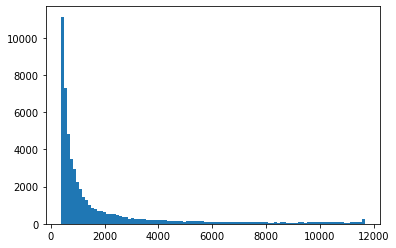

In [173]:
#distribution of the intensity of the events lasting more than a year

fig, ax = plt.subplots(1, 1)
ax.hist(np.array(lowflow.intensity[lowflow.intensity>365]).flatten(),bins=100)

## Getting rid of exposures far from rivers and to close to the coast

In [10]:
# this data is built ith different layers from quantiles of river size, the following files were
# needed to reach a sufficient level of detail
# https://www.bafg.de/GRDC/EN/Home/homepage_node.html

rivers1 = gpd.read_file('/home/stalzel/Python_projects/climada/low_flow/rivers/mrb_rivnets_Q09_10.shp')
rivers2 = gpd.read_file('/home/stalzel/Python_projects/climada/low_flow/rivers/mrb_rivnets_Q08_09.shp')
rivers3 = gpd.read_file('/home/stalzel/Python_projects/climada/low_flow/rivers/mrb_rivnets_Q07_08.shp')
rivers4 = gpd.read_file('/home/stalzel/Python_projects/climada/low_flow/rivers/mrb_rivnets_Q06_07.shp')


In [11]:
rivers1.head()

RIVER_BASI CONTINENT           OCEAN             SEA  AREA_CALC  \
0               ATOUI    Africa  Atlantic Ocean  North Atlantic    27695.3   
1             BANDAMA    Africa  Atlantic Ocean  Gulf of Guinea    99253.9   
2                 BIA    Africa  Atlantic Ocean  Gulf of Guinea    10957.0   
3             CAVALLY    Africa  Atlantic Ocean  Gulf of Guinea    29622.7   
4  CESTOS (also NUON)    Africa  Atlantic Ocean  North Atlantic    12785.1   

   Shape_Leng  MRBID                                           geometry  
0    4.092204   1201  LINESTRING (-14.00208333333333 22.202083333332...  
1   13.885620   1202  (LINESTRING (-4.827083333333519 5.947916666666...  
2    1.051965   1203  LINESTRING (-3.227083333333525 6.0187499999993...  
3    3.372281   1204  LINESTRING (-7.943750000000165 6.2979166666660...  
4    1.435313   1205  LINESTRING (-8.839583333333422 6.0979166666660...

In [12]:
def min_distance(point, lines):
    return lines.distance(point).min()

n=1
for rivers in [rivers1,rivers2,rivers3,rivers4]:
    nuclear_exp["".join(['min_dist_to_lines',str(n)])] = nuclear_exp.geometry.apply(min_distance, args=(rivers,))
    n=n+1

nuclear_exp['min_dist_to_lines']=nuclear_exp.iloc[:,29:].min(axis=1)
nuclear_close_to_rivers = nuclear_exp[(nuclear_exp['min_dist_to_lines']<0.1)]


In [15]:
nuclear_close_to_rivers

country              country_long                            name  \
72        ARG                 Argentina                        ATUCHA I   
73        ARG                 Argentina                       ATUCHA II   
197       ARG                 Argentina                         EMBALSE   
294       ARM                   Armenia                      Armenian-2   
978       BEL                   Belgium                      TIHANGE 1N   
979       BEL                   Belgium                       TIHANGE 3   
3395      BGR                  Bulgaria                        KOZLODUY   
3691      CAN                    Canada                      Darlington   
4191      CAN                    Canada                     Pickering A   
4192      CAN                    Canada                     Pickering B   
4972      CHN                     China                            CEFR   
8080      CZE            Czech Republic                        Dukonavy   
8348      CZE            Czech Republic                         Temelín   
8723      FIN                   Finland                      Loviisa Y1   
8943      FRA                    France                      BELLEVILLE   
8951      FRA                    France                           BUGEY   
9105      FRA                    France                        CATTENOM   
9108      FRA                    France                          CHINON   
9109      FRA                    France                           CHOOZ   
9110      FRA                    France                          CIVAUX   
9117      FRA                    France                           CRUAS   
9325      FRA                    France                       DAMPIERRE   
9392      FRA                    France                      FESSENHEIM   
9465      FRA                    France                         GOLFECH   
10035     FRA                    France                          NOGENT   
10327     FRA                    France                        ST ALBAN   
10329     FRA                    France                      ST LAURENT   
10645     FRA                    France                     TRICASTIN 1   
11161     DEU                   Germany                         Grohnde   
11321     DEU                   Germany                          ISAR-2   
...       ...                       ...                             ...   
23414     USA  United States of America                           Fermi   
23910     USA  United States of America                      Grand Gulf   
24053     USA  United States of America                    H B Robinson   
24147     USA  United States of America                          Harris   
24525     USA  United States of America                  Indian Point 2   
24526     USA  United States of America                  Indian Point 3   
24767     USA  United States of America                 Joseph M Farley   
25010     USA  United States of America      LaSalle Generating Station   
25193     USA  United States of America                        Limerick   
25586     USA  United States of America                         McGuire   
25865     USA  United States of America     Monticello Nuclear Facility   
26356     USA  United States of America                          Oconee   
26593     USA  United States of America                       Palisades   
26603     USA  United States of America                      Palo Verde   
26675     USA  United States of America                    Peach Bottom   
26724     USA  United States of America                           Perry   
26941     USA  United States of America                  Prairie Island   
27014     USA  United States of America  Quad Cities Generating Station   
27039     USA  United States of America   R E Ginna Nuclear Power Plant   
27252     USA  United States of America                      River Bend   
27664     USA  United States of America                        Seabrook   
27704     USA  United States of

In [14]:
nuclear_close_to_rivers = nuclear_close_to_rivers.drop(nuclear_close_to_rivers.columns[29:], axis=1)

In [17]:
nuclear_close_to_rivers = Exposures(nuclear_close_to_rivers)
nuclear_close_to_rivers.crs = {'init': 'epsg:4326'}
nuclear_close_to_rivers['dist_to_coast'] = dist_to_coast(nuclear_close_to_rivers) #get the distance to coast 
nuclear_close_to_rivers = nuclear_close_to_rivers[nuclear_close_to_rivers['dist_to_coast']>1000] # dist to coast is in meters

2020-06-30 17:32:22,634 - climada.util.coordinates - INFO - dist_to_coast: UTM 32611 (1/96)
2020-06-30 17:32:23,068 - climada.util.coordinates - INFO - dist_to_coast: UTM 32612 (3/96)
2020-06-30 17:32:23,538 - climada.util.coordinates - INFO - dist_to_coast: UTM 32614 (7/96)
2020-06-30 17:32:24,112 - climada.util.coordinates - INFO - dist_to_coast: UTM 32615 (9/96)
2020-06-30 17:32:25,168 - climada.util.coordinates - INFO - dist_to_coast: UTM 32616 (11/96)
2020-06-30 17:32:26,119 - climada.util.coordinates - INFO - dist_to_coast: UTM 32617 (13/96)
2020-06-30 17:32:27,158 - climada.util.coordinates - INFO - dist_to_coast: UTM 32618 (15/96)
2020-06-30 17:32:28,433 - climada.util.coordinates - INFO - dist_to_coast: UTM 32720 (20/96)
2020-06-30 17:32:28,757 - climada.util.coordinates - INFO - dist_to_coast: UTM 32721 (22/96)
2020-06-30 17:32:29,256 - climada.util.coordinates - INFO - dist_to_coast: UTM 32630 (39/96)
2020-06-30 17:32:30,080 - climada.util.coordinates - INFO - dist_to_coast:

In [18]:
len(nuclear_close_to_rivers)/len(nuclear_exp)

0.5252525252525253

(35.0, 65.0)

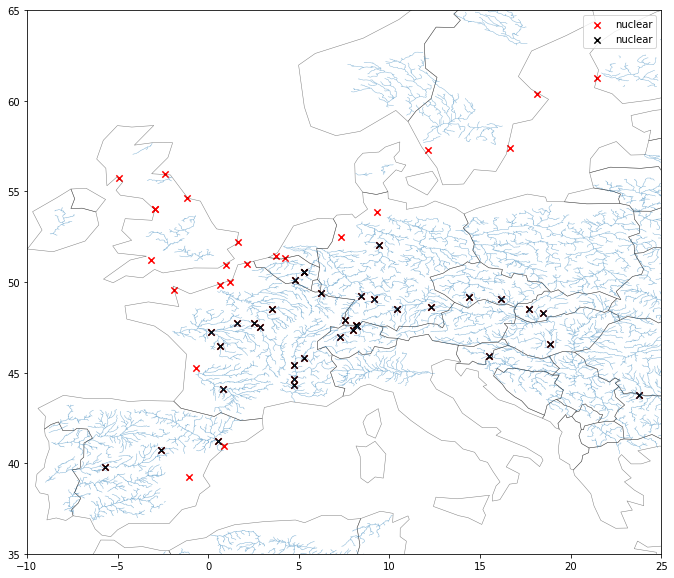

In [19]:
#ax,fig = plt.subplots()
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = rivers1.plot(figsize=(15,10), linewidth=0.5,alpha=0.5)
world.boundary.plot(ax=ax,color='Black', linewidth=0.5,alpha=0.5)
rivers2.plot(linewidth=0.5,ax=ax,alpha=0.5)
rivers3.plot(linewidth=0.5,ax=ax,alpha=0.5)
rivers4.plot(linewidth=0.5,ax=ax,alpha=0.5)
nuclear_exp.plot(ax=ax,color='Red',markersize=40,label='nuclear',marker='x')
nuclear_close_to_rivers.plot(ax=ax,markersize=40,label='nuclear',marker='x',color='Black')

ax.legend()
ax.set_xlim(-10, 25)
ax.set_ylim(35, 65)
ax.set_title('Nuclear Power Plants')


Text(0.5, 1.0, 'Nuclear Power Plants')

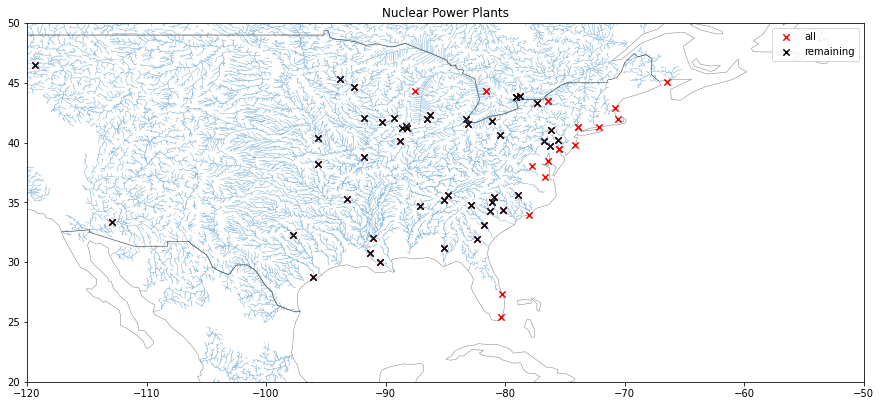

In [52]:
#ax,fig = plt.subplots()
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = rivers1.plot(figsize=(15,10), linewidth=0.5,alpha=0.5)
world.boundary.plot(ax=ax,color='Black', linewidth=0.5,alpha=0.5)
rivers2.plot(linewidth=0.5,ax=ax,alpha=0.5)
rivers3.plot(linewidth=0.5,ax=ax,alpha=0.5)
rivers4.plot(linewidth=0.5,ax=ax,alpha=0.5)
#coal_close_to_rivers.plot(ax=ax,color='Black',markersize=5,label='coal')
#gas_close_to_rivers.plot(ax=ax,color='Blue',markersize=5, label='gas')
#hydro_close_to_rivers.plot(ax=ax,color='Green',markersize=5,label='hydro')
nuclear_exp.plot(ax=ax,color='Red',markersize=40,label='all',marker='x')
nuclear_close_to_rivers.plot(ax=ax,markersize=40,label='remaining',marker='x',color='Black')

ax.legend()
ax.set_xlim(-120, -50)
ax.set_ylim(20, 50)
ax.set_title('Nuclear Power Plants')


In [21]:
n=1
for rivers in [rivers1,rivers2,rivers3,rivers4]:
    gas_exp["".join(['min_dist_to_lines',str(n)])] = gas_exp.geometry.apply(min_distance, args=(rivers,))
    n=n+1

gas_exp['min_dist_to_lines']=gas_exp.iloc[:,29:].min(axis=1)
gas_close_to_rivers = gas_exp[(gas_exp['min_dist_to_lines']<0.1)]
gas_close_to_rivers = gas_close_to_rivers.drop(gas_close_to_rivers.columns[29:], axis=1)
gas_close_to_rivers = Exposures(gas_close_to_rivers)
gas_close_to_rivers.crs = {'init': 'epsg:4326'}
gas_close_to_rivers['dist_to_coast'] = dist_to_coast(gas_close_to_rivers) #get the distance to coast 
gas_close_to_rivers = gas_close_to_rivers[gas_close_to_rivers['dist_to_coast']>1000] # dist to coast is in meters

2020-06-30 17:41:09,358 - climada.util.coordinates - INFO - dist_to_coast: UTM 32610 (1/102)
2020-06-30 17:41:10,201 - climada.util.coordinates - INFO - dist_to_coast: UTM 32611 (3/102)
2020-06-30 17:41:11,208 - climada.util.coordinates - INFO - dist_to_coast: UTM 32612 (5/102)
2020-06-30 17:41:12,528 - climada.util.coordinates - INFO - dist_to_coast: UTM 32613 (7/102)
2020-06-30 17:41:13,655 - climada.util.coordinates - INFO - dist_to_coast: UTM 32614 (9/102)
2020-06-30 17:41:15,064 - climada.util.coordinates - INFO - dist_to_coast: UTM 32615 (11/102)
2020-06-30 17:41:16,497 - climada.util.coordinates - INFO - dist_to_coast: UTM 32616 (13/102)
2020-06-30 17:41:18,269 - climada.util.coordinates - INFO - dist_to_coast: UTM 32617 (15/102)
2020-06-30 17:41:19,895 - climada.util.coordinates - INFO - dist_to_coast: UTM 32717 (16/102)
2020-06-30 17:41:20,245 - climada.util.coordinates - INFO - dist_to_coast: UTM 32618 (17/102)
2020-06-30 17:41:21,983 - climada.util.coordinates - INFO - dist_

Text(0.5, 1.0, 'Gas Power Plants')

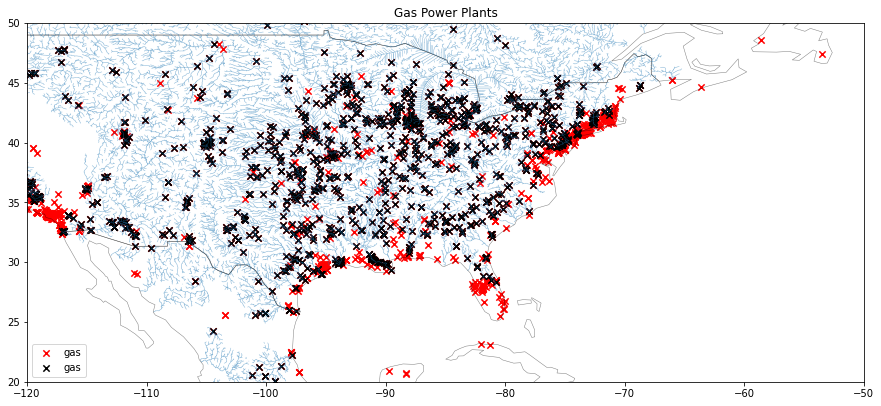

In [26]:
#ax,fig = plt.subplots()
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = rivers1.plot(figsize=(15,10), linewidth=0.5,alpha=0.5)
world.boundary.plot(ax=ax,color='Black', linewidth=0.5,alpha=0.5)
rivers2.plot(linewidth=0.5,ax=ax,alpha=0.5)
rivers3.plot(linewidth=0.5,ax=ax,alpha=0.5)
rivers4.plot(linewidth=0.5,ax=ax,alpha=0.5)
#coal_close_to_rivers.plot(ax=ax,color='Black',markersize=5,label='coal')
#gas_close_to_rivers.plot(ax=ax,color='Blue',markersize=5, label='gas')
#hydro_close_to_rivers.plot(ax=ax,color='Green',markersize=5,label='hydro')
gas_exp.plot(ax=ax,color='Red',markersize=40,label='all',marker='x')
gas_close_to_rivers.plot(ax=ax,markersize=40,label='remaining',marker='x',color='Black')

ax.legend()
ax.set_xlim(-120, -50)
ax.set_ylim(20, 50)
ax.set_title('Gas Power Plants')

In [39]:
n=1
for rivers in [rivers1,rivers2,rivers3,rivers4]:
    coal_exp["".join(['min_dist_to_lines',str(n)])] = coal_exp.geometry.apply(min_distance, args=(rivers,))
    n=n+1

coal_exp['min_dist_to_lines']=coal_exp.iloc[:,29:].min(axis=1)
coal_close_to_rivers = coal_exp[(coal_exp['min_dist_to_lines']<0.1)]
coal_close_to_rivers = coal_close_to_rivers.drop(coal_close_to_rivers.columns[29:], axis=1)
coal_close_to_rivers = Exposures(coal_close_to_rivers)
coal_close_to_rivers.crs = {'init': 'epsg:4326'}
coal_close_to_rivers['dist_to_coast'] = dist_to_coast(coal_close_to_rivers) #get the distance to coast 
coal_close_to_rivers = coal_close_to_rivers[coal_close_to_rivers['dist_to_coast']>1000] # dist to coast is in meters

2020-06-30 17:54:31,551 - climada.util.coordinates - INFO - dist_to_coast: UTM 32606 (1/110)
2020-06-30 17:54:32,914 - climada.util.coordinates - INFO - dist_to_coast: UTM 32611 (11/110)
2020-06-30 17:54:34,017 - climada.util.coordinates - INFO - dist_to_coast: UTM 32612 (13/110)
2020-06-30 17:54:35,355 - climada.util.coordinates - INFO - dist_to_coast: UTM 32613 (15/110)
2020-06-30 17:54:36,482 - climada.util.coordinates - INFO - dist_to_coast: UTM 32614 (17/110)
2020-06-30 17:54:37,805 - climada.util.coordinates - INFO - dist_to_coast: UTM 32615 (19/110)
2020-06-30 17:54:39,290 - climada.util.coordinates - INFO - dist_to_coast: UTM 32616 (21/110)
2020-06-30 17:54:40,859 - climada.util.coordinates - INFO - dist_to_coast: UTM 32617 (23/110)
2020-06-30 17:54:42,704 - climada.util.coordinates - INFO - dist_to_coast: UTM 32618 (25/110)
2020-06-30 17:54:44,469 - climada.util.coordinates - INFO - dist_to_coast: UTM 32619 (27/110)
2020-06-30 17:54:45,781 - climada.util.coordinates - INFO - d

Text(0.5, 1.0, 'Coal Power Plants')

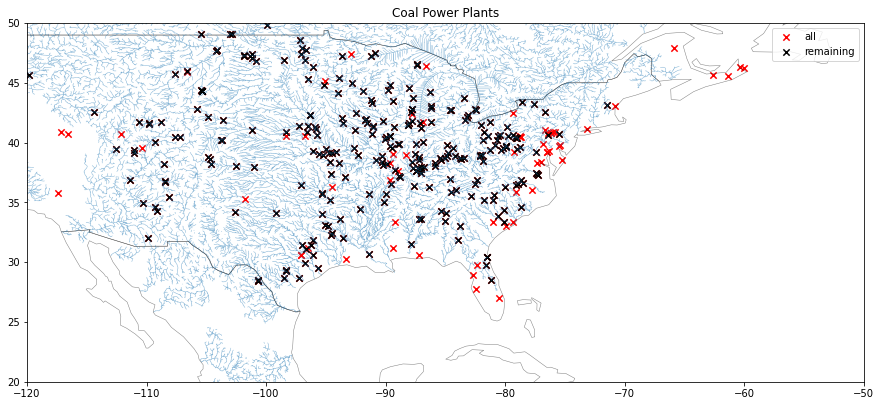

In [44]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = rivers1.plot(figsize=(15,10), linewidth=0.5,alpha=0.5)
world.boundary.plot(ax=ax,color='Black', linewidth=0.5,alpha=0.5)
rivers2.plot(linewidth=0.5,ax=ax,alpha=0.5)
rivers3.plot(linewidth=0.5,ax=ax,alpha=0.5)
rivers4.plot(linewidth=0.5,ax=ax,alpha=0.5)
#coal_close_to_rivers.plot(ax=ax,color='Black',markersize=5,label='coal')
#coal_close_to_rivers.plot(ax=ax,color='Blue',markersize=5, label='coal')
#hydro_close_to_rivers.plot(ax=ax,color='Green',markersize=5,label='hydro')
coal_exp.plot(ax=ax,color='Red',markersize=40,label='all',marker='x')
coal_close_to_rivers.plot(ax=ax,markersize=40,label='remaining',marker='x',color='Black')

ax.legend()
ax.set_xlim(-120, -50)
ax.set_ylim(20, 50)
ax.set_title('Coal Power Plants')

### what portion of gas pp are close to rivers in israel?

In [47]:
len(gas_close_to_rivers[gas_close_to_rivers['country_long']=='Israel'])/len(gas_exp[gas_exp['country_long']=='Israel'])

0.05555555555555555

In [51]:
len(gas_exp[gas_exp['country_long']=='Israel'])

18